In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import argrelextrema
from tqdm.notebook import tqdm
import mplfinance as mpf

import sys

sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [18, 10]
sns.set()

In [2]:
def bar_create(ohlc,what = 'transfers_volume_sum',th=5):
    df = ohlc.copy()
    group = pd.Series(index = df.index, dtype = float, name = 'group')
    N = len(group)

    t = ohlc[what] #100*np.log(ohlc['Close']/ohlc['Open'])
    ts = 0
    idx = []

    for i, x in enumerate(t):
        ts += x
        if np.abs(ts) > th:
            idx.append(i)
            ts = 0.0
            continue

    group.iloc[idx]  = idx
    group.fillna(method = 'bfill',inplace = True)
    group.fillna(method = 'ffill',inplace = True)

    df.loc[:,'group'] = group
    df.loc[:,'Time'] = df.index

    fTime = df.groupby('group')['Time'].first()
    lTime = df.groupby('group')['Time'].last()
    Time_ = pd.concat([fTime,lTime],axis = 1)
    Time_.columns = ['open','close']
    Time_.index = Time_.close
    Time_.loc[:,'dt'] = (Time_.close-Time_.open).dt.total_seconds()


    Open = df.groupby('group')['Open'].first()
    High = df.groupby('group')['High'].max()
    Low = df.groupby('group')['Low'].min()
    Close = df.groupby('group')['Close'].last()

    newOhlc = pd.concat([Open,High,Low,Close],axis = 1)
    newOhlc.index = lTime
    return newOhlc,group

def check_direction(R):
    pos = (R>0) & (R.shift(1)>0)
    neg = (R<=0) & (R.shift(1)<=0)

    mask = pos | neg
    return mask.sum()/mask.count()

In [3]:
Urls['transfers_volume_sum'] = 'https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum'
Urls['ssr'] = 'https://api.glassnode.com/v1/metrics/indicators/ssr'

In [4]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc = ohlc.loc[:'2019']

selected = ['marketcap_usd',
            'mvrv_z_score',
            'sopr',
            'sopr_adjusted',
            'puell_multiple',
            'net_unrealized_profit_loss',
            'ssr',
            'transfers_volume_sum',
            'transfers_volume_exchanges_net',
            'dormancy_flow',
            'reserve_risk']

features = get_glassnode_data(selected,Urls)
features = features.loc[:'2019']

  0%|          | 0/11 [00:00<?, ?it/s]

cannot get ssr.


# Puell multiple

- Cycle top > 4
- Local Top < 4 and >3
- Cycle bottom < 0.5

In [5]:
def local_min_max(df,col,L):
    df[col+'_ma_'+str(L)] = df[col].rolling(L).mean()
    x = df[col+'_ma_'+str(L)].copy()
    
    Lmin = x.loc[(x.shift(1)>x) & (x.shift(-1)>x)].rename(col+'_min')
    Lmax = x.loc[(x.shift(1)<x) & (x.shift(-1)<x)].rename(col+'_max')
    
    df_ = pd.concat([df,Lmin,Lmax],axis = 1)
    
    return df_

In [6]:
df = pd.concat([ohlc.Close,features['puell_multiple']],axis = 1).dropna()
df = local_min_max(df,'puell_multiple',20).copy()
df['log_puell_ma'] = np.log(df['puell_multiple_ma_20'])

<AxesSubplot:xlabel='t'>

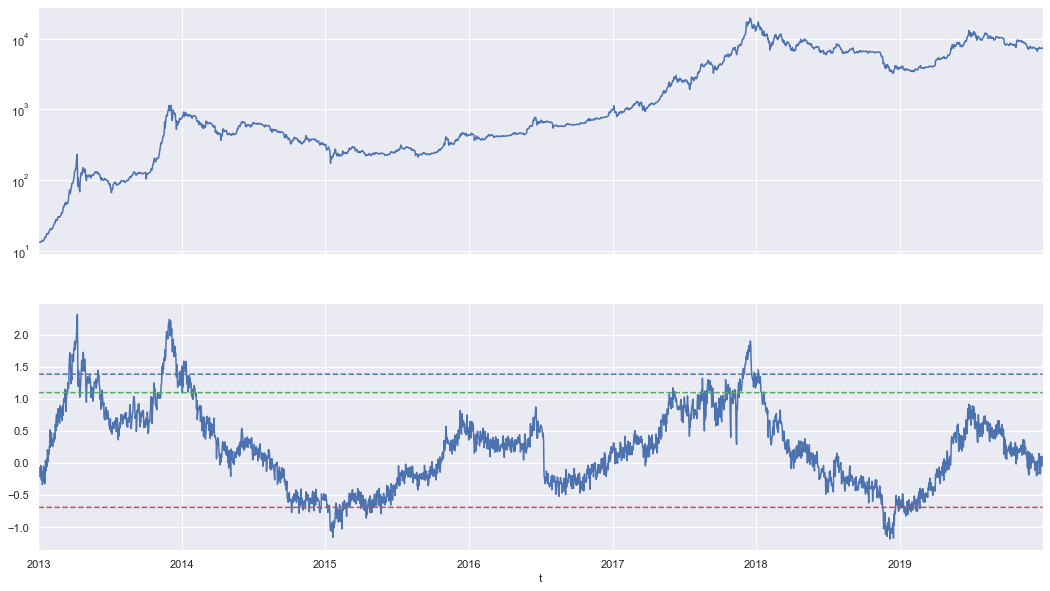

In [7]:
cycle_top = pd.Series(4,index = df.index)
local_top = pd.Series(3,index = df.index)
cycle_bottom = pd.Series(0.5,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [8]:
df['R']=100*(df.Close/df.Close.shift(1)-1)
# df = df.dropna().copy()

df['q_puell'] = pd.qcut(df['log_puell_ma'].diff(20).shift(1),3)

avg = df.groupby('q_puell')['R'].apply(lambda x: x.mean()/x.std()).rename('std_avg')
prc = df.groupby('q_puell')['R'].apply(lambda x: x[x>0].count()/x.count()).rename('prc')
cnt = df.groupby('q_puell')['R'].count().rename('N')

pd.concat([avg,prc,cnt],axis=1)


,std_avg,prc,N
q_puell,,,
"(-0.776, -0.074]",0.017513,0.498212,839
"(-0.074, 0.0718]",0.037532,0.539379,838
"(0.0718, 0.823]",0.136515,0.591180,839


In [9]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean())

above 4: 1.2870098243094774
between 3 and 4: 0.7262436206084021
between 0.5 and 3: 0.29926533168038644
below 0.5: 0.03153066483013202


In [10]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean()/df.loc[df.puell_multiple.shift(1)>4,'R'].std())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].std())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].std())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean()/df.loc[(df.puell_multiple.shift(1)<0.5),'R'].std())


above 4: 0.11014420087871257
between 3 and 4: 0.12092540101830619
between 0.5 and 3: 0.07943725620627495
below 0.5: 0.00586075229256107


In [11]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','puell_multiple']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 6.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['puell_multiple']],axis=1).dropna()


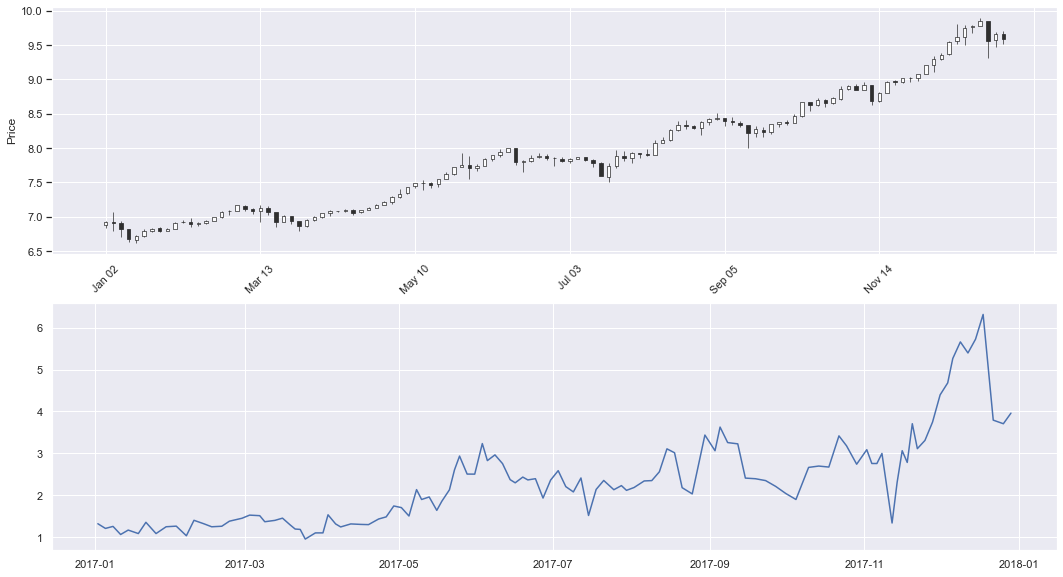

In [12]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017','puell_multiple'])

In [13]:
newOhlc['R'] = 100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 4:',
      newOhlc.loc[newOhlc.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<4) & (newOhlc.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<3) & (newOhlc.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<0.5),'R'].mean())

above 4: 7.438375415084582
between 3 and 4: 3.208538390656524
between 0.5 and 3: 1.3816815865631253
below 0.5: 0.47563761839171426


# Reserve risk

<AxesSubplot:>

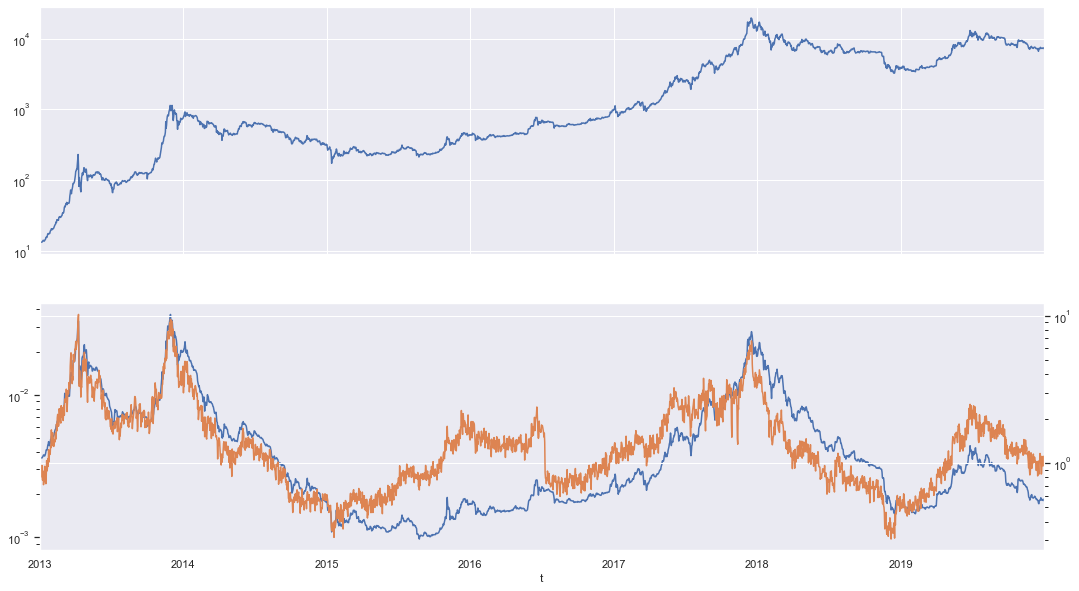

In [14]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple']]],axis = 1).dropna()


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

df['reserve_risk'].plot(ax = a[1],logy=True)
df['puell_multiple'].plot(ax = a[1],logy=True,secondary_y=True)


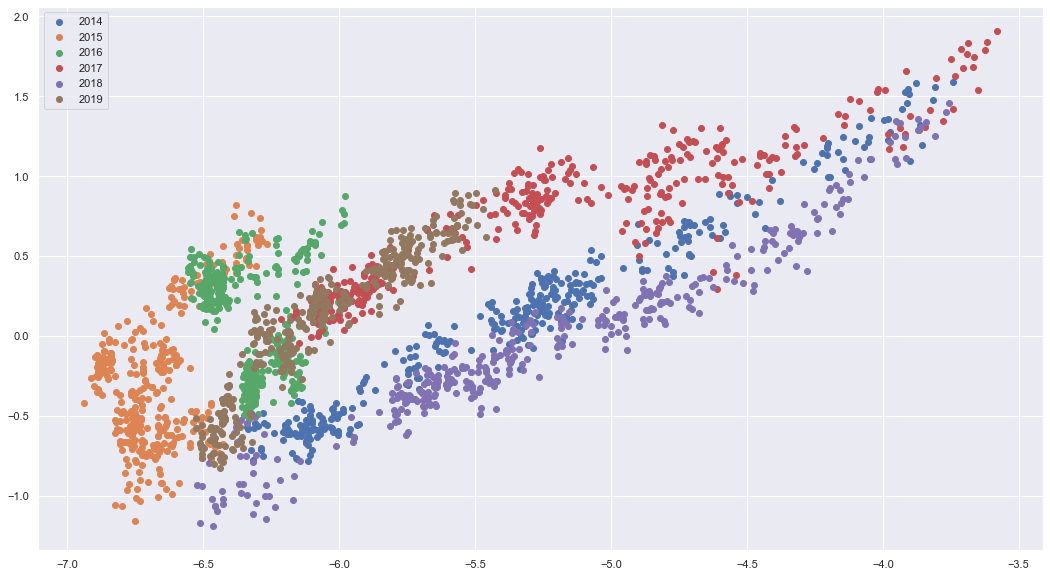

In [15]:
years = np.unique(df.index.year)

for y in years[1:]:
    plt.scatter(np.log(df.loc[str(y)].reserve_risk),
                np.log(df.loc[str(y)].puell_multiple),label = y)
    
plt.legend()

<AxesSubplot:xlabel='t'>

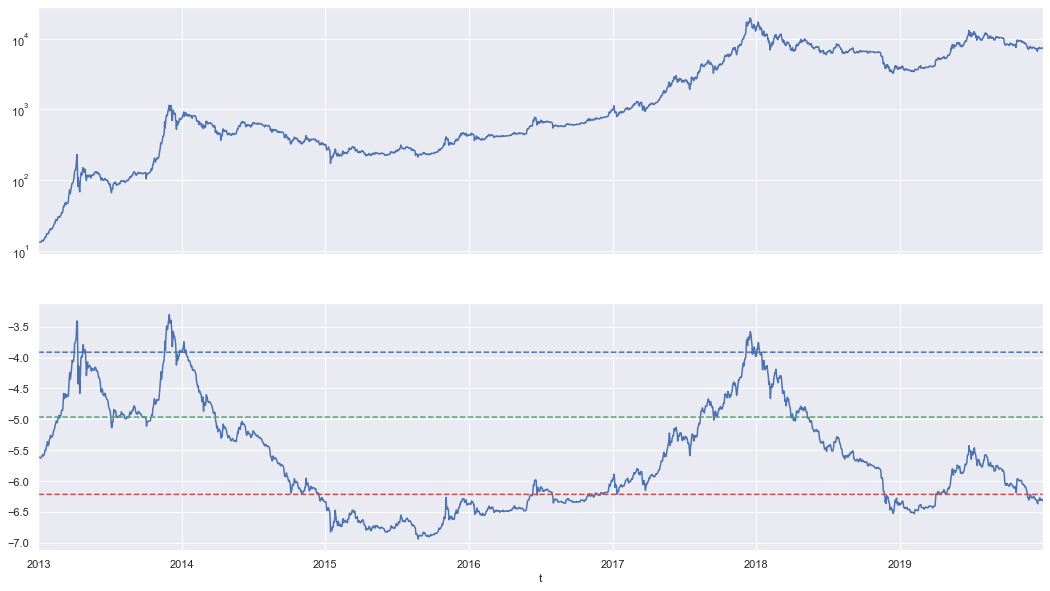

In [16]:
cycle_top = pd.Series(0.02,index = df.index)
local_top = pd.Series(0.007,index = df.index)
cycle_bottom = pd.Series(0.002,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['reserve_risk']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [17]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 0.02:',
      df.loc[df.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      df.loc[(df.reserve_risk.shift(1)<0.02) & (df.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.007) & (df.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -0.9143459834042467
between 0.02 and 0.007: 0.974704039681219
between 0.007 and 0.002: 0.2669585401449922
below 0.002: 0.19535049021444956


In [18]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','reserve_risk']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 3.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['reserve_risk']],axis=1).dropna()


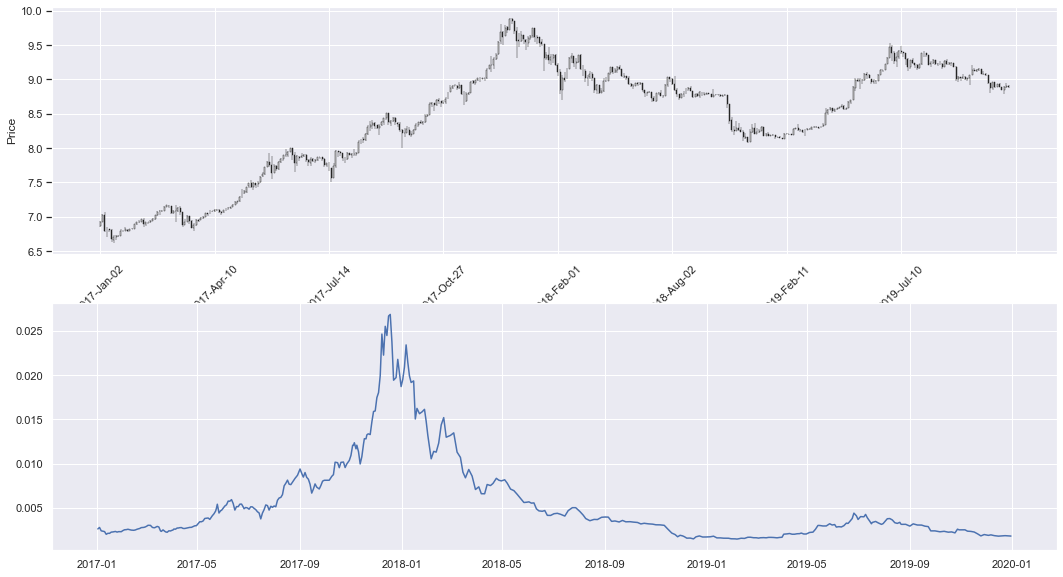

In [19]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017':'2019',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017':'2019','reserve_risk'])

In [20]:
newOhlc['R']=100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 0.02:',
      newOhlc.loc[newOhlc.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.02) & (newOhlc.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.007) & (newOhlc.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -1.0255915208734552
between 0.02 and 0.007: 2.8311342921276372
between 0.007 and 0.002: 0.8799413414873575
below 0.002: 0.5445817658759498


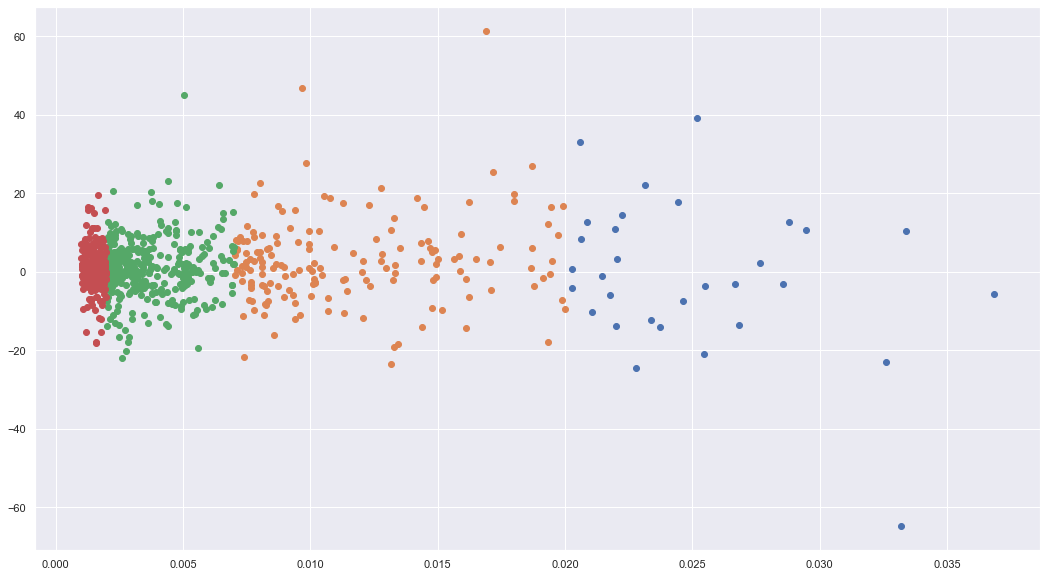

In [21]:
newOhlc['LRR'] = newOhlc.reserve_risk.shift(1)

plt.scatter(newOhlc.loc[newOhlc['LRR']>0.02,'LRR'],
            newOhlc.loc[newOhlc['LRR']>0.02,'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.002),'R'])


# Adjusted SOPR

<AxesSubplot:xlabel='t'>

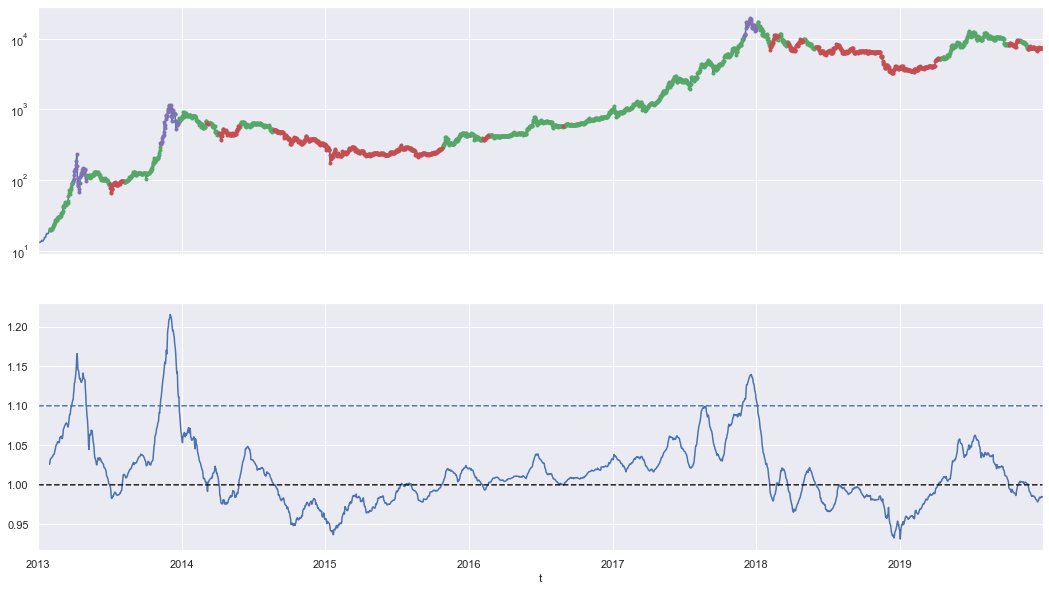

In [22]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1.1,index = df.index)
cycle_bottom = pd.Series(1.,index = df.index)


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

df['sopr_adjusted_ma'].plot(ax = a[1])
cycle_top.plot(ax = a[1],style = 'b--')
cycle_bottom.plot(ax = a[1],style = 'k--')


In [23]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1.1:',
      df.loc[df.sopr_adjusted_ma.shift(1)>0.02,'R'].mean())
print('between 1.1 and 1.0:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.1) & (df.sopr_adjusted_ma.shift(1)>1.) ,'R'].mean())
print('below 1:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.),'R'].mean())

above 1.1: 0.34349855068317586
between 1.1 and 1.0: 0.3657317567159199
below 1: 0.08158381937293982


<AxesSubplot:xlabel='t'>

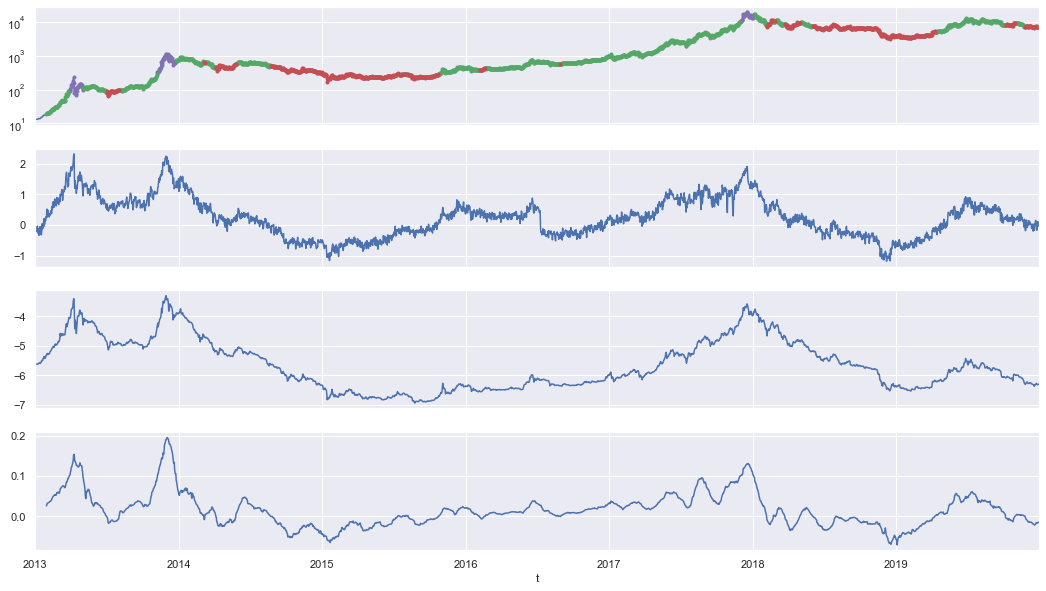

In [24]:
f,a = plt.subplots(nrows = 4, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(df['reserve_risk']).plot(ax = a[2])
np.log(df['sopr_adjusted_ma']).plot(ax = a[3])


In [25]:
df[['puell_multiple','reserve_risk','sopr_adjusted_ma']].corr()


,puell_multiple,reserve_risk,sopr_adjusted_ma
puell_multiple,1.000000,0.892491,0.881169
reserve_risk,0.892491,1.000000,0.758557
sopr_adjusted_ma,0.881169,0.758557,1.000000


# Entity 

<AxesSubplot:xlabel='t'>

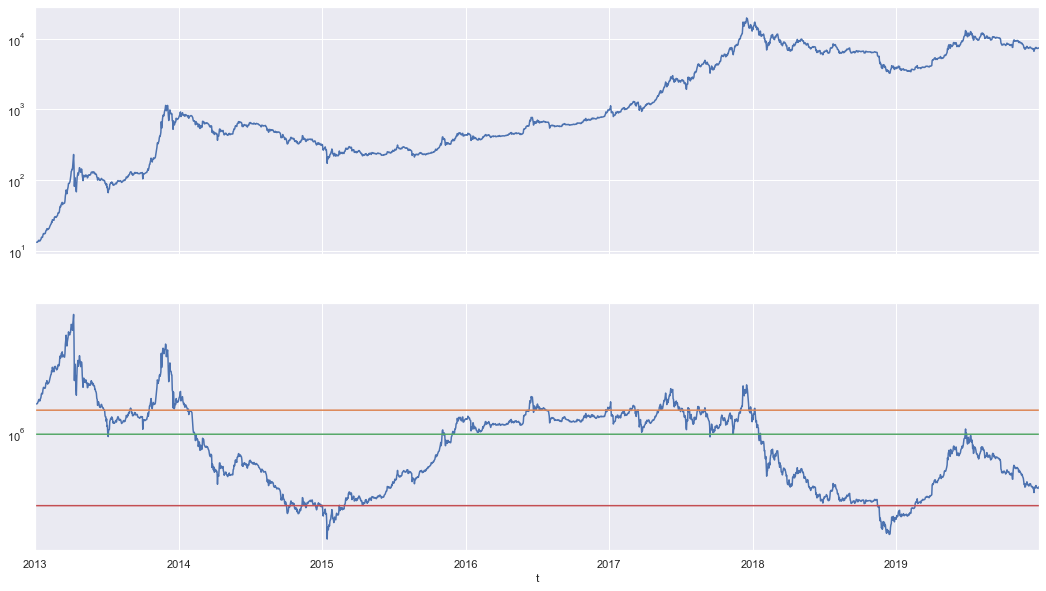

In [26]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted','dormancy_flow']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1500000,index = df.index)
local_top = pd.Series(1000000,index = df.index)
cycle_bottom = pd.Series(300000,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['dormancy_flow'].plot(ax = a[1],logy = True)

cycle_top.plot(ax = a[1],logy = True)
local_top.plot(ax = a[1],logy = True)
cycle_bottom.plot(ax = a[1],logy = True)


In [27]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1,500,000:',
      df.loc[df.dormancy_flow.shift(1)>1500000,'R'].mean())
print('between 1,500,000 and 1,000,000:',
      df.loc[(df.dormancy_flow.shift(1)<1500000) & (df.dormancy_flow.shift(1)>1000000) ,'R'].mean())
print('between 1,000,000 and 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<1000000) & (df.dormancy_flow.shift(1)>300000) ,'R'].mean())
print('below 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<300000),'R'].mean())

above 1,500,000: 1.1110977334827845
between 1,500,000 and 1,000,000: 0.44776347266917554
between 1,000,000 and 300,000: 0.06800252101400657
below 300,000: 0.014754819090005216


# Cointegration

In [28]:
df = pd.concat([ohlc,features],axis = 1).dropna().loc['2014':]

In [29]:
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
\
pd.options.display.float_format = '{:,.4f}'.format

cols = features.columns

Coint = []
ADF = []

N = df.shape[0]
medpx = np.log(df[['High','Low']].mean(1)).rename('medpx')

for c in cols:
    data = pd.DataFrame()
    
    if (df[c]>=0).sum() == N:
        x = np.log(df[c])
    else:
        x = df[c]
        
    data = pd.concat([medpx,x],axis=1).dropna()

    period = data.index.strftime('%Y')
    cnt = data.groupby(period).apply(lambda x: ts.coint(x['medpx'],x[c],trend='ctt')[1]).rename(c)
    adf = data.groupby(period)[c].apply(lambda x: adfuller(x,regression='ctt')[1]).rename(c)
    Coint.append(cnt)
    ADF.append(adf)
    
Coint = pd.concat(Coint,axis=1)
ADF = pd.concat(ADF,axis=1)

print('Cointegration')
print('-------------')
display(Coint)
print('')
print('Unit root')
print('---------')
display(ADF)

Cointegration
-------------


,marketcap_usd,mvrv_z_score,sopr,sopr_adjusted,puell_multiple,net_unrealized_profit_loss,transfers_volume_sum,transfers_volume_exchanges_net,dormancy_flow,reserve_risk
t,,,,,,,,,,
2014,0.0000,0.1494,0.8503,0.8505,0.0000,0.0697,0.7898,0.8182,0.3589,0.6240
2015,0.0000,0.0303,0.6836,0.4719,0.3011,0.6824,0.6581,0.4426,0.8129,0.0000
2016,0.0000,0.6416,0.8259,0.8365,0.5570,0.5876,0.8586,0.6955,0.8579,0.1470
2017,0.0000,0.3325,0.4410,0.6658,0.0218,0.3819,0.4963,0.3983,0.3714,0.5652
2018,0.0000,0.6165,0.6446,0.7112,0.0598,0.0382,0.3790,0.2627,0.4106,0.0582
2019,0.0000,0.1837,0.5595,0.5848,0.1137,0.9819,0.4391,0.5225,0.9948,0.9991



Unit root
---------


,marketcap_usd,mvrv_z_score,sopr,sopr_adjusted,puell_multiple,net_unrealized_profit_loss,transfers_volume_sum,transfers_volume_exchanges_net,dormancy_flow,reserve_risk
t,,,,,,,,,,
2014,0.7945,0.7074,0.0000,0.0000,0.6154,0.4011,0.0375,0.0000,0.7472,0.6952
2015,0.2799,0.3513,0.0001,0.0000,0.1566,0.4303,0.0002,0.0000,0.1996,0.3271
2016,0.7336,0.8553,0.0759,0.0061,0.8797,0.2360,0.0000,0.0000,0.6427,0.7163
2017,0.3549,0.0508,0.0001,0.0073,0.0489,0.0931,0.5275,0.0000,0.3479,0.1805
2018,0.0463,0.1741,0.0001,0.0001,0.1608,0.2110,0.1656,0.0000,0.0139,0.3518
2019,0.2838,0.3582,0.0000,0.0000,0.1931,0.1745,0.0050,0.0000,0.4198,0.3069


<AxesSubplot:>

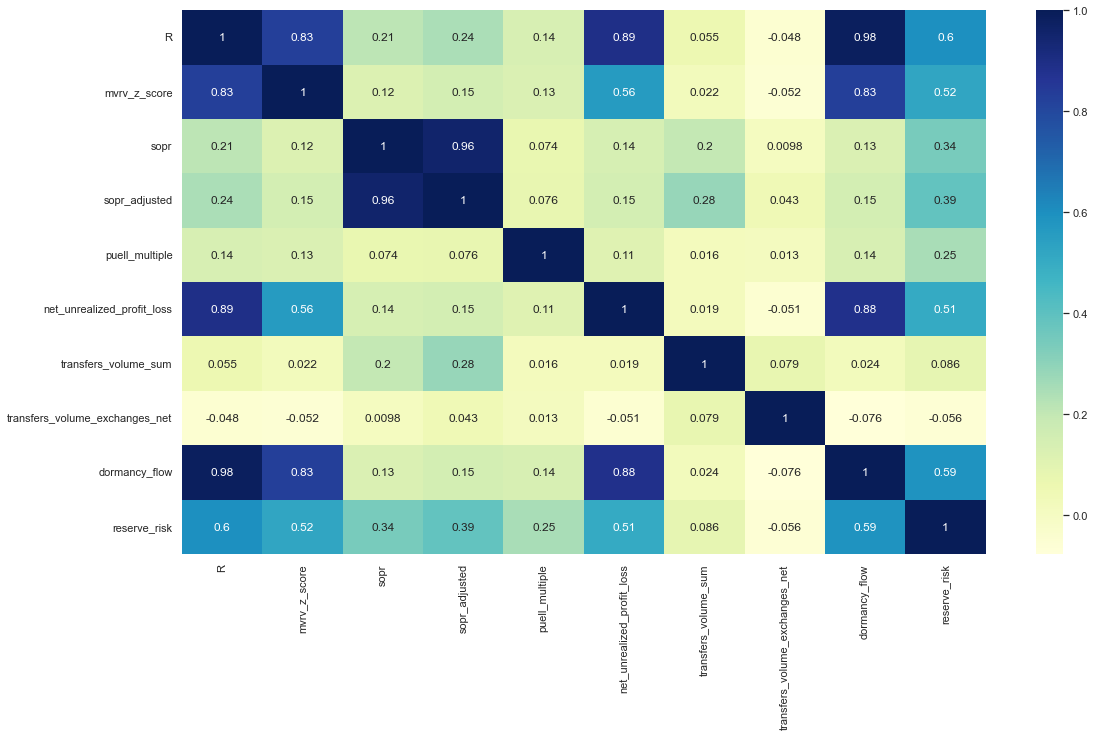

In [30]:
R = 100*np.log(df['Close']/df['Open']).rename('R')

Rdf = [R]

for c in cols:
    if c != 'marketcap_usd':
        if (df[c]>=0).sum() == N:
            x = np.log(df[c])
        else:
            x = df[c]

        pval = adfuller(x,regression='ctt')[1]

        if pval<0.1:
            Rdf.append(x)
        else:
            Rdf.append(x.diff())
        
Rdf = pd.concat(Rdf,axis=1).dropna()
sns.heatmap(Rdf.corr(),annot=True,cmap="YlGnBu")

# Create Targets

In [31]:
import talib as ta

px = np.log(ohlc.Close)
wpx = np.log(ta.WCLPRICE(ohlc.High, ohlc.Low, ohlc.Close))

upperband, middleband, lowerband = ta.BBANDS(px,
                                             timeperiod=12, 
                                             nbdevup=2, 
                                             nbdevdn=2, 
                                             matype=0)

# real = ta.HT_DCPERIOD(ohlc.Close)
# real = ta.ADXR(ohlc.High, ohlc.Low, ohlc.Close, timeperiod=14)
# real = ta.HT_TRENDLINE(np.log(ohlc.Close))
real = ta.CCI(np.log(ohlc.High), np.log(ohlc.Low), np.log(ohlc.Close), timeperiod=12)


<AxesSubplot:xlabel='t'>

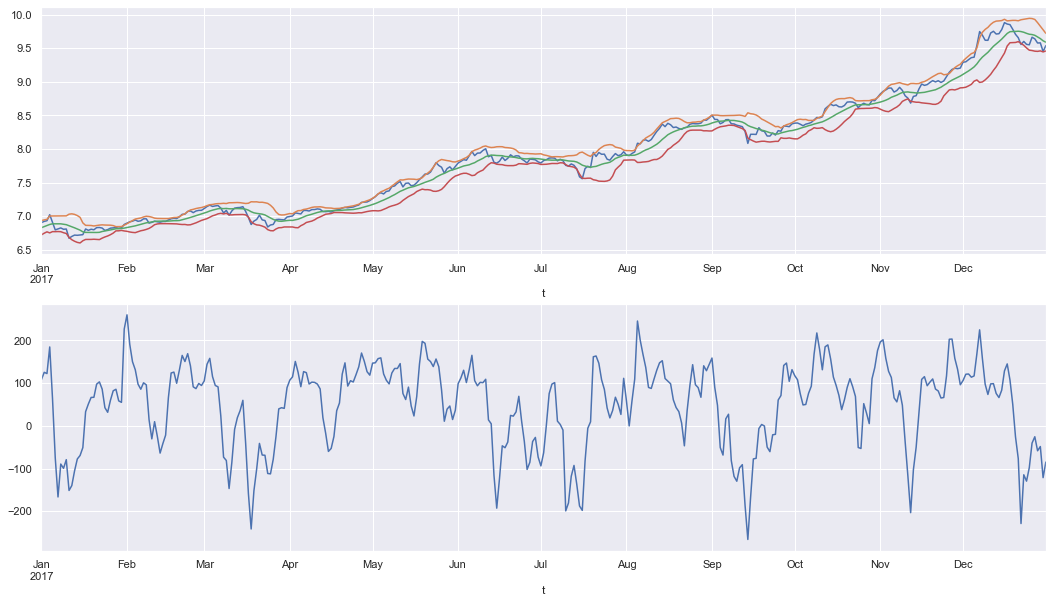

In [32]:
f,a = plt.subplots(nrows=2)
px.loc['2017'].plot(ax=a[0])
upperband.loc['2017'].plot(ax=a[0])
middleband.loc['2017'].plot(ax=a[0])
lowerband.loc['2017'].plot(ax=a[0])
real.loc['2017'].plot(ax=a[1])


In [132]:
target_df = pd.DataFrame(px)

target_df['R'] = 100*px.diff()
target_df['RV'] = np.sqrt((target_df['R']**2).rolling(30).sum())
target_df['FR'] = 100*(px.shift(-30) - px)
target_df['FR2RV'] = target_df['FR']/target_df['RV']
target_df['Target'] = 0.
target_df.loc[target_df.FR2RV>=1.,'Target']=1.
target_df.loc[target_df.FR2RV<=-1.,'Target']=-1.

target_df = target_df.dropna()

In [174]:
# f,a = plt.subplots(nrows=2)
# target_df.loc['2017','Close'].plot(ax=a[0])
# target_df.loc[target_df.Target==1,'Close'].loc['2017'].plot(ax=a[0],style = 'go')
# target_df.loc[target_df.Target==-1,'Close'].loc['2017'].plot(ax=a[0],style = 'ro')
# target_df.loc[:,'RV'].loc['2017'].plot(ax=a[1])

In [247]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

def on_chain_classifier(data,train_period,cv_period,
                        freqency = '%Y-%m',options = {'max_depth':3}):
    
    train_data = data.loc[data.index.strftime(freqency).isin(train_period)]
    
    try:
        cv_data = data.loc[data.index.strftime(freqency).isin(cv_period)]
    except:
        cv_data = data.loc[data.index.strftime(freqency).isin([cv_period])]
        
    y_train,X_train = train_data['Target'],train_data.loc[:,train_data.columns != 'Target']
    y_cv,X_cv = cv_data['Target'],cv_data.loc[:,cv_data.columns != 'Target']
    
    clf = DecisionTreeClassifier(random_state=0,max_depth = options['max_depth'])
    clf.fit(X_train,y_train)
    yhat_cv = pd.Series(clf.predict(X_cv),index = y_cv.index,name = 'y_hat_cv')
    res = pd.concat([yhat_cv,y_cv],axis=1)
    return res

In [299]:

selected = ['mvrv_z_score',
            'sopr_adjusted',
            'puell_multiple',
            'net_unrealized_profit_loss',
            'dormancy_flow',
            'reserve_risk']



feats = features[selected]# .rolling(60).mean()

data = pd.concat([target_df['Target'],feats],axis=1).dropna()

dates = np.unique(data.index.strftime('%Y-%U'))
strided_dates = strided_app(dates,52,1)
M = strided_dates.shape[0]

results = [
    on_chain_classifier(data,
                        strided_dates[t,:-1],
                        strided_dates[t,-1],
                        freqency = '%Y-%U',
                        options = {'max_depth':6})
    
    for t in tqdm(range(M))]

results = pd.concat(results,axis=0).sort_index()
print('accuracy:',accuracy_score(results.Target,results.y_hat_cv))

  0%|          | 0/316 [00:00<?, ?it/s]

accuracy: 0.7015200368493781


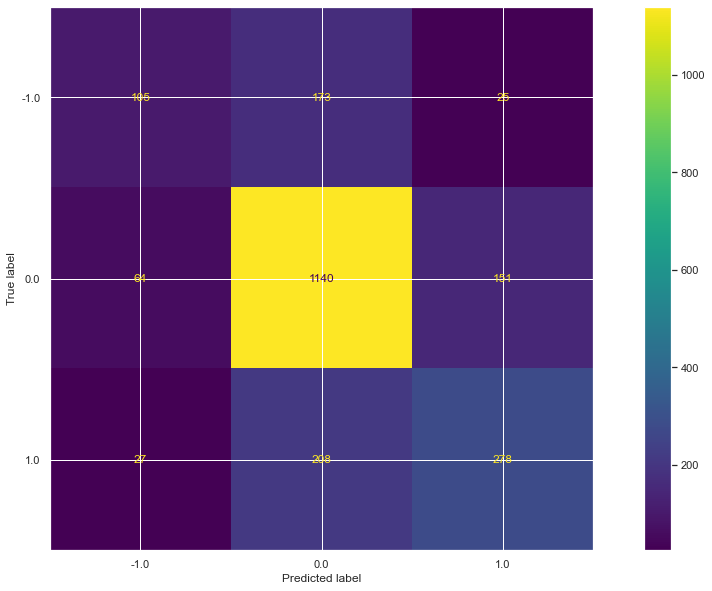

In [300]:
cm = confusion_matrix(results.Target, results.y_hat_cv)  
ConfusionMatrixDisplay.from_predictions(results.Target, results.y_hat_cv)

In [301]:
print('% 1:',cm[-1,2]/cm[:,2].sum())
print('% -1:',cm[0,0]/cm[:,0].sum())
print('% 0:',cm[1,1]/cm[:,1].sum())

% 1: 0.6123348017621145
% -1: 0.5357142857142857
% 0: 0.7495069033530573
